Step 1. Importing all libries 

In [29]:
# Data Handling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


2: Load Dataset

In [ ]:
# Load the dataset (update filename if different)
df = pd.read_csv('data/bank-additional-full.csv', sep=';')

# Preview
df.head()


3: Inspect Dataset Structure

In [ ]:
# View dimensions
print("Dataset shape:", df.shape)

# Check data types and non-null counts
print("\n--- DataFrame Info ---")
df.info()

# Summary statistics (numerical + categorical)
print("\n--- Descriptive Statistics (including categorical) ---")
display(df.describe(include='all'))

# Check missing values
print("\n--- Missing Values Count ---")
print(df.isnull().sum())

# Preview unique values in some key categorical columns
print("\n--- Unique Values in 'job', 'education', 'poutcome' ---")
print("job:", df['job'].unique())
print("education:", df['education'].unique())
print("poutcome:", df['poutcome'].unique())


4 – Replace "unknown" with NaN and summarize

In [ ]:
import numpy as np

# Replace 'unknown' with np.nan
df.replace("unknown", np.nan, inplace=True)

# Check missing values again
print("Missing values after replacing 'unknown':\n")
print(df.isnull().sum())

# Optional: percentage of missing per column
print("\nPercentage of missing values per column:\n")
print((df.isnull().sum() / len(df) * 100).round(2))


5 – Impute Missing Values

In [ ]:
# Fill categorical columns with mode (safe method)
for col in ['education', 'job', 'marital', 'housing', 'loan']:
    df[col] = df[col].fillna(df[col].mode()[0])

# For 'default', fill with mode safely
df['default'] = df['default'].fillna(df['default'].mode()[0])

# Confirm no missing values
print("✅ Missing values after imputation:\n")
print(df.isnull().sum())


6 – Encode Categorical Variables

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the DataFrame to preserve the original
df_encoded = df.copy()

# Binary columns: encode with LabelEncoder
binary_cols = ['default', 'housing', 'loan', 'y']
le = LabelEncoder()
for col in binary_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# One-hot encode all other categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=[
    'job', 'marital', 'education', 'contact', 
    'month', 'day_of_week', 'poutcome'
], drop_first=True)

# Show result
print("✅ Categorical variables encoded.")
print("Encoded DataFrame shape:", df_encoded.shape)


 7 – Encode Target + Correlation Analysis + Feature Insight

✅ Target variable encoded.



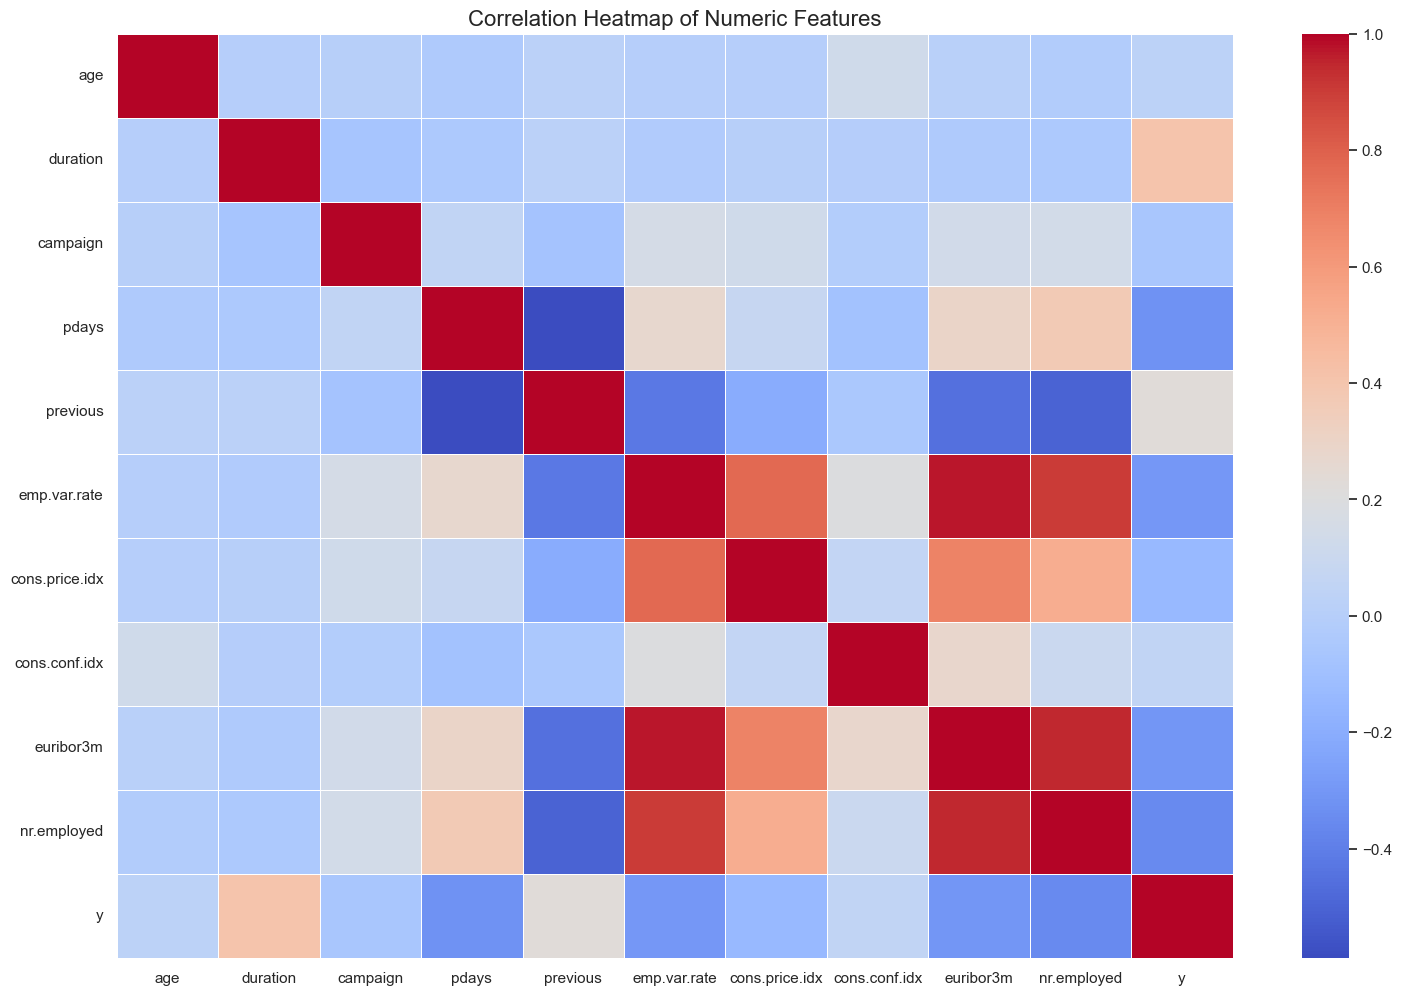


⚠️ Highly correlated features (|corr| > 0.85):
       Feature 1    Feature 2  Correlation
42  emp.var.rate    euribor3m     0.972245
52     euribor3m  nr.employed     0.945154
43  emp.var.rate  nr.employed     0.906970


In [35]:
# Encode target variable 'y' to binary (1 for 'yes', 0 for 'no')
df['y'] = df['y'].map({'yes': 1, 'no': 0})

print("✅ Target variable encoded.\n")

# Optional: Correlation matrix (numeric columns only)
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

# Optional: Identify highly correlated pairs
threshold = 0.85
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Correlation'].abs() > threshold]

# Print high correlation pairs (for potential feature reduction)
if not high_corr_pairs.empty:
    print("\n⚠️ Highly correlated features (|corr| > 0.85):")
    print(high_corr_pairs.sort_values(by='Correlation', ascending=False))
else:
    print("\n✅ No highly correlated feature pairs above threshold (0.85).")


DROPPING HIGHLY CORRELATED FEATURES 

In [36]:
# Drop 'emp.var.rate' and 'nr.employed' (keep only 'euribor3m')
df.drop(['emp.var.rate', 'nr.employed'], axis=1, inplace=True)
print("✅ Dropped 'emp.var.rate' and 'nr.employed' due to high multicollinearity.")



✅ Dropped 'emp.var.rate' and 'nr.employed' due to high multicollinearity.


8. TRAINING THE MODEL

In [37]:
# Cell 8 – Train/Test Split

from sklearn.model_selection import train_test_split
import joblib  # for saving split objects

# 1️⃣ Separate features and target
X = df.drop('y', axis=1)
y = df['y']

print("Feature matrix shape (X):", X.shape)
print("Target vector shape (y):", y.shape)

# 2️⃣ Perform an 80/20 stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("\n✅ Train/Test split complete:")
print(f"  • X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  • X_test : {X_test.shape}, y_test : {y_test.shape}")

# 3️⃣ Save splits so other members can load them directly
#    Adjust file paths as needed (e.g., a 'data/' or 'splits/' subfolder)
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test,  'X_test.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test,  'y_test.pkl')

print("\n✅ Saved X_train, X_test, y_train, y_test to disk (pickle files).")


Feature matrix shape (X): (41188, 18)
Target vector shape (y): (41188,)

✅ Train/Test split complete:
  • X_train: (32950, 18), y_train: (32950,)
  • X_test : (8238, 18), y_test : (8238,)

✅ Saved X_train, X_test, y_train, y_test to disk (pickle files).
